In [1]:
# Install required libraries
!pip install -q kaggle opencv-python tensorflow

In [2]:
# from google.colab import files
# files.upload()  # Upload kaggAle.json manually

In [3]:
# Set up Kaggle API (assumes kaggle.json is uploaded)
# import os
# os.makedirs('/root/.kaggle', exist_ok=True)
# Upload kaggle.json manually in Colab before running
# !cp kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

In [4]:
import os

os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

In [5]:
# Download and unzip dataset
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!unzip -o lung-and-colon-cancer-histopathological-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not found, falling back to CPU/GPU")
    strategy = tf.distribute.get_strategy()

TPU not found, falling back to CPU/GPU


In [8]:
# Define paths and parameters
IMG_SIZE = 128  # Optimized for speed
BATCH_SIZE = 128  # Increased for TPU efficiency
EPOCHS = 10
SPLIT = 0.2
path_lung = './lung_colon_image_set/lung_image_sets'

In [9]:
# Detect classes
classes = [d for d in os.listdir(path_lung) if os.path.isdir(os.path.join(path_lung, d))]
print("Detected classes:", classes)

Detected classes: ['lung_n', 'lung_aca', 'lung_scc']


In [10]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=SPLIT
)

train_generator = train_datagen.flow_from_directory(
    path_lung,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    path_lung,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [11]:
# Build MobileNetV2 model within TPU strategy scope
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze initially

    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(len(classes), activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Define callbacks
es = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print("\n✅ Validation accuracy reached 90%, stopping training.")
            self.model.stop_training = True

In [13]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[es, lr, checkpoint, myCallback()]
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8110 - loss: 0.4608
Epoch 1: val_accuracy improved from -inf to 0.94567, saving model to best_model.h5



✅ Validation accuracy reached 90%, stopping training.
94/94 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8118 - loss: 0.4587 - val_accuracy: 0.9457 - val_loss: 0.1532 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# Plot training metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Fine-tune MobileNetV2
with strategy.scope():
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) - int(len(base_model.layers) * 0.1)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [15]:
# Continue training
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[es, lr, checkpoint, myCallback()]
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9142 - loss: 0.2131
Epoch 1: val_accuracy did not improve from 0.94567
94/94 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.9144 - loss: 0.2126 - val_accuracy: 0.8810 - val_loss: 0.4034 - learning_rate: 1.0000e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9551 - loss: 0.1171
Epoch 2: val_accuracy did not improve from 0.94567

✅ Validation accuracy reached 90%, stopping training.
94/94 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.9551 - loss: 0.1170 - val_accuracy: 0.9050 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.


In [16]:
# Save final model
model.save('fine_tuned_lung_colon_classifier.h5')

In [ ]:
# Evaluate the model after initial training
print("Evaluating model after initial training:")

# Make predictions on the validation data
Y_pred_initial = model.predict(val_images)

# Convert predicted probabilities to class labels
Y_pred_classes_initial = np.argmax(Y_pred_initial, axis=1)

# Get the true class labels from the validation data (assuming val_labels is already available)
# Y_true_classes = np.argmax(val_labels, axis=1) # This was already done in a previous cell

# Print the classification report to evaluate model performance
print("\nClassification Report (After Initial Training):")
print(classification_report(Y_true_classes, Y_pred_classes_initial, target_names=classes))

# Generate and plot the confusion matrix
conf_matrix_initial = confusion_matrix(Y_true_classes, Y_pred_classes_initial)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_initial, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (After Initial Training)')
plt.show()

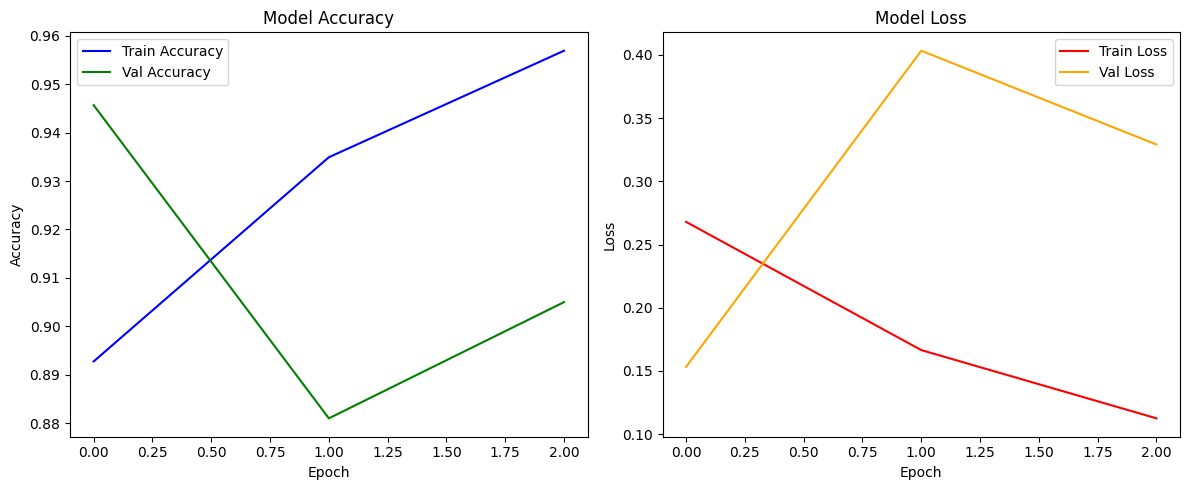

In [17]:
# Plot training metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Evaluate model
val_images, val_labels = [], []
for _ in range(len(val_generator)):
    imgs, lbls = next(val_generator)
    val_images.append(imgs)
    val_labels.append(lbls)
val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels)

Y_pred = model.predict(val_images)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(val_labels, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 352ms/step


In [19]:
# Classification report
print(classification_report(Y_true_classes, Y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

      lung_n       0.99      0.73      0.84      1000
    lung_aca       0.98      1.00      0.99      1000
    lung_scc       0.80      0.99      0.88      1000

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.90      3000
weighted avg       0.92      0.91      0.90      3000



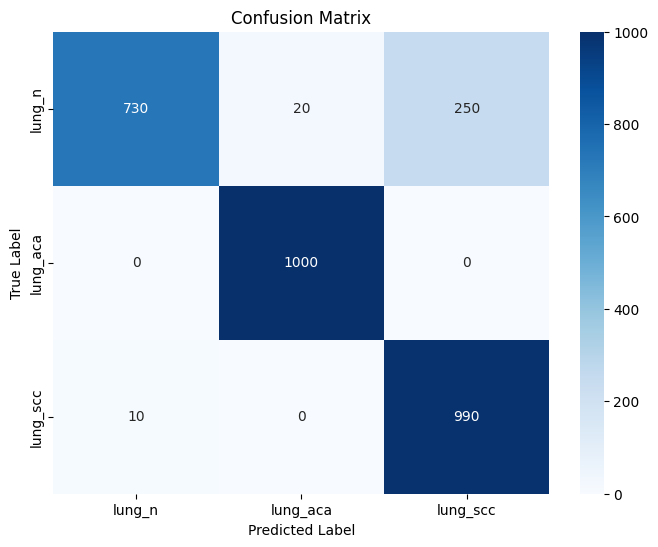

In [20]:
# Confusion matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Define a new input tensor with the same shape as the model's input
    input_tensor = tf.keras.Input(shape=model.input_shape[1:])

    # Get the base model layer from the main model
    base_model_layer = model.get_layer('mobilenetv2_1.00_128')

    # Pass the input tensor through the base model layer to get its output
    x = base_model_layer(input_tensor)

    # Create a functional model that maps the input tensor to the activations of the last convolutional layer in the base model
    grad_model_intermediate = tf.keras.models.Model(
        inputs=input_tensor,
        outputs=base_model_layer.get_layer(last_conv_layer_name).output
    )

    # Pass the input tensor through the rest of the model's layers to get the final prediction
    # This requires knowing the layers after the base model and how they are connected.
    # Based on the model summary in the notebook, the layers after the base model are GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Dense
    x_final = tf.keras.layers.GlobalAveragePooling2D()(base_model_layer.output)
    x_final = model.get_layer('dense')(x_final)
    x_final = model.get_layer('dropout')(x_final)
    x_final = model.get_layer('batch_normalization')(x_final)
    final_output = model.get_layer('dense_1')(x_final)

    # Create a functional model that maps the input tensor to the final predictions
    grad_model_final = tf.keras.models.Model(
        inputs=input_tensor,
        outputs=final_output
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last convolutional layer
    with tf.GradientTape() as tape:
        # Get the output of the last convolutional layer from the intermediate model
        last_conv_layer_output = grad_model_intermediate(img_array)
        # Ensure this intermediate output is watched by the tape
        tape.watch(last_conv_layer_output)
        # Get the predictions from the final model
        preds = grad_model_final(img_array)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with respect to the output feature map of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a channel of the feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is"
    # with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_array, heatmap, alpha=0.4):
    # Assuming img_array is already the correctly shaped and scaled image array
    img = img_array[0] * 255
    img = np.uint8(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap, origin='lower')
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    return keras.preprocessing.image.array_to_img(superimposed_img)

In [34]:
# Grad-CAM Visualization
# Get the name of the last convolutional layer in the base model
last_conv_layer_name = None
for layer in reversed(model.get_layer('mobilenetv2_1.00_128').layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    print("Could not find a convolutional layer in the base model.")
else:
    print(f"Last convolutional layer in base model: {last_conv_layer_name}")

    # Get a few example images from the validation set
    num_examples = 5
    # Use val_images and val_labels from cell eKIcUOL692nd
    example_images = val_images[:num_examples]
    example_labels = val_labels[:num_examples] # Use val_labels directly

    plt.figure(figsize=(15, 6))
    for i in range(num_examples):
        img_array = np.expand_dims(example_images[i], axis=0)
        # img_array is already normalized from the data generator or previous processing

        # Get the true class name
        # If val_labels is one-hot encoded, get the index of the true class
        true_class_index = np.argmax(example_labels[i])
        true_class_name = classes[true_class_index]

        # Generate heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Display original image
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(example_images[i])
        plt.title(f"Original\n({true_class_name})")
        plt.axis('off')

        # Display superimposed image
        plt.subplot(2, num_examples, num_examples + i + 1)
        superimposed_img = display_gradcam(example_images[i:i+1], heatmap) # Pass a slice to keep dimension
        # Explicitly convert the superimposed image to a NumPy array for plotting
        superimposed_img_np = np.array(superimposed_img)
        plt.imshow(superimposed_img_np)
        plt.title("Grad-CAM")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Last convolutional layer in base model: Conv_1


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m139365126740816\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.6117647 , 0.4784314 , 0.8588236 ],\n         [0.6117647 , 0.4784314 , 0.8588236 ],\n         [0.6117647 , 0.4784314 , 0.8588236 ],\n         ...,\n         [0.74273926, 0.65646476, 0.94273925],\n         [0.7375012 , 0.65122664, 0.9375012 ],\n         [0.73226315, 0.64598864, 0.9322632 ]],\n\n        [[0.6117647 , 0.4784314 , 0.8588236 ],\n         [0.6117647 , 0.4784314 , 0.8588236 ],\n         [0.6117647 , 0.4784314 , 0.8588236 ],\n         ...,\n         [0.7585616 , 0.65528303, 0.9269827 ],\n         [0.7648473 , 0.65790206, 0.92645884],\n         [0.77113295, 0.6605211 , 0.9259351 ]],\n\n        [[0.6117647 , 0.4784314 , 0.8588236 ],\n         [0.6117647 , 0.4784314 , 0.8588236 ],\n         [0.6117647 , 0.4784314 , 0.8588236 ],\n         ...,\n         [0.77647066, 0.6695536 , 0.92322075],\n         [0.77647066, 0.671125  , 0.922697  ],\n         [0.77647066, 0.67269635, 0.92217314]],\n\n        ...,\n\n        [[0.62601715, 0.5313839 , 0.8808739 ],\n         [0.61856127, 0.52827275, 0.8815526 ],\n         [0.6007518 , 0.508892  , 0.8679337 ],\n         ...,\n         [0.49653673, 0.34476686, 0.7948082 ],\n         [0.47289604, 0.32942536, 0.78897893],\n         [0.44971323, 0.31273985, 0.7850029 ]],\n\n        [[0.5084661 , 0.40846345, 0.79736227],\n         [0.4906568 , 0.3890827 , 0.7837433 ],\n         [0.48469487, 0.3803646 , 0.7803922 ],\n         ...,\n         [0.495635  , 0.34545627, 0.8048257 ],\n         [0.49552026, 0.35871822, 0.8107439 ],\n         [0.49849766, 0.36170164, 0.8260391 ]],\n\n        [[0.47383773, 0.35322174, 0.7803922 ],\n         [0.4717425 , 0.34798372, 0.7803922 ],\n         [0.470353  , 0.34439233, 0.78180367],\n         ...,\n         [0.4971933 , 0.34612915, 0.80720735],\n         [0.5166226 , 0.3835217 , 0.823727  ],\n         [0.55845886, 0.4289361 , 0.84232235]]]], dtype=float32)\n  • training=None\n  • mask=None'

<Figure size 1500x600 with 0 Axes>